# E-Commerce: Identifying Consumer Profiles - Everything Plus Store

# Content <a id='back'></a>

* [1) Project Objetive](#projectgoal)
* [2) Data Preparation](#data_preprocessing)
* [3) Exploratory Data Analysis (EDA)](#eda)
  *  [3.1) Initial Visualizations](#initialvis)
  *  [3.2) Relationship Analysis](#relationshipanalysis)
  *  [3.3) Outliners](#outliners)
* [4) User Segmentation Based on Purchase History](#segmentation)
  * [4.1) Definition of Segmentation Criteria](#definitionsegmentation)
  * [4.2) Application of Clustering Algorithms](#clusteringalgorithmsapplication)
* [5) Statistical Hypothesis Testing](#statisticalhypothesistest)
* [6) Conclusion and Recommmendations](#endandrecommmendations)
  * [6.1) Conclusion](#end)
  * [6.2) Recommmendations](#recommmendations)
  * [6.3) Dashboards](#dash)
  * [6.4) Final Report and Presentation](#finalreport)
* [7) References](#references)

## Project Objetive 

The main objective of this project is to analyze and segment the consumers of the Everything Plus store based on their purchasing behavior, using data analysis and machine learning techniques. The consumer segmentation aims to identify distinct profiles, allowing the company to develop personalized marketing strategies, such as creating targeted offers, promoting products, and retention campaigns.

## Data Preparation

The first step is to gather the data containing information about consumers and their purchases. After collecting it, it will be necessary to perform a cleaning process to ensure the data is ready for analysis.

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from math import factorial
import datetime as dt
from scipy import stats
from scipy.stats import ttest_ind

In [2]:
# Load the dataset
ecommerce_data = pd.read_csv('/datasets/ecommerce_dataset_us.csv', sep=None, engine='python')

In [3]:
ecommerce_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,11/29/2018 08:26,2.55,17850.0
1,536365,71053,WHITE METAL LANTERN,6,11/29/2018 08:26,3.39,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,11/29/2018 08:26,2.75,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,11/29/2018 08:26,3.39,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,11/29/2018 08:26,3.39,17850.0


In [4]:
ecommerce_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB


In [5]:
# Convert the InvoiceDate column to datetime format
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'], errors='coerce')

The InvoiceDate column has been successfully converted to a datetime64 format. This will allow us to perform time-based analysis, such as grouping by date or time intervals.

In [6]:
# Check for missing values
missing_values = ecommerce_data.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
dtype: int64


The Description column has 1,454 missing values. And the CustomerID column has 135,080 missing values, which might be significant for customer analysis.

In [7]:
# Check for duplicate rows
duplicate_rows = ecommerce_data.duplicated().sum()
print(duplicate_rows)

5268


There are 5,268 duplicate rows in the dataset.

In [8]:
# Remove duplicate rows
ecommerce_data = ecommerce_data.drop_duplicates()

In [9]:
# For Description, fill missing values with 'Unknown'
ecommerce_data['Description'].fillna('Unknown', inplace=True)

# For CustomerID, drop rows with missing CustomerID values
ecommerce_data = ecommerce_data.dropna(subset=['CustomerID'])

# Verify the changes by checking for missing values and duplicates again
missing_values_after_cleaning = ecommerce_data.isnull().sum()
print(missing_values_after_cleaning)
print()
duplicate_rows_after_cleaning = ecommerce_data.duplicated().sum()
print(duplicate_rows_after_cleaning)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
dtype: int64

0


The dataset is clean and ready for further analysis.

In [10]:
ecommerce_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  object        
 1   StockCode    401604 non-null  object        
 2   Description  401604 non-null  object        
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 24.5+ MB


In [11]:
# rename column names
ecommerce_data = ecommerce_data.rename(columns={
    'InvoiceNo': 'invoice_no',
    'StockCode': 'stock_code',
    'Description': 'description',
    'Quantity': 'quantity',
    'InvoiceDate': 'invoice_date',
    'UnitPrice': 'unit_price',
    'CustomerID': 'customer_id'
})

ecommerce_data.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id'],
      dtype='object')

Let's Create New Variables: Derive new columns that will be useful for future analyses.

* **Total Purchase Value:** Total value of each purchase (quantity * unit price).
* **Purchase Frequency:** Number of unique purchases per customer.
* **Recency:** Days since the last purchase for each customer..

In [12]:
# Create a new column for total purchase value (quantity * unit_price)
ecommerce_data['total_purchase'] = ecommerce_data['quantity'] * ecommerce_data['unit_price']

# Calculate purchase frequency by customer
purchase_frequency = ecommerce_data.groupby('customer_id')['invoice_no'].nunique().reset_index()
purchase_frequency.columns = ['customer_id', 'purchase_frequency']

# Calculate recency (days since last purchase)
most_recent_date = ecommerce_data['invoice_date'].max()

# Calculate the difference between the most recent date and each customer's last purchase
recency = ecommerce_data.groupby('customer_id')['invoice_date'].max().reset_index()
recency['recency_days'] = (most_recent_date - recency['invoice_date']).dt.days

# Merge the new variables (purchase_frequency and recency) back into the dataset
ecommerce_data = ecommerce_data.merge(purchase_frequency, on='customer_id', how='left')
ecommerce_data = ecommerce_data.merge(recency[['customer_id', 'recency_days']], on='customer_id', how='left')


ecommerce_data.head()


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,total_purchase,purchase_frequency,recency_days
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2018-11-29 08:26:00,2.55,17850.0,15.30,35,301
1,536365,71053,WHITE METAL LANTERN,6,2018-11-29 08:26:00,3.39,17850.0,20.34,35,301
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2018-11-29 08:26:00,2.75,17850.0,22.00,35,301
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2018-11-29 08:26:00,3.39,17850.0,20.34,35,301
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2018-11-29 08:26:00,3.39,17850.0,20.34,35,301


**Summary of this stage:** 

In the data preparation phase, we cleaned the dataset by handling missing values, removing duplicates, and standardizing column names. We created new variables: total_purchase (total value per transaction), purchase_frequency (number of unique transactions per customer), and recency_days (days since the last purchase). These steps provide key insights into customer behavior, preparing the data for further analysis.

## Exploratory Data Analysis (EDA)

Exploratory data analysis is the phase where you explore the data to understand patterns, trends, and variables of interest. At this stage, it is essential to create visualizations that provide an overview of consumer behavior and the most purchased product categories.

### Initial Visualizations

Let's begin the Exploratory Data Analysis (EDA) by creating some initial visualizations. We'll start with histograms to explore the distribution of key variables.

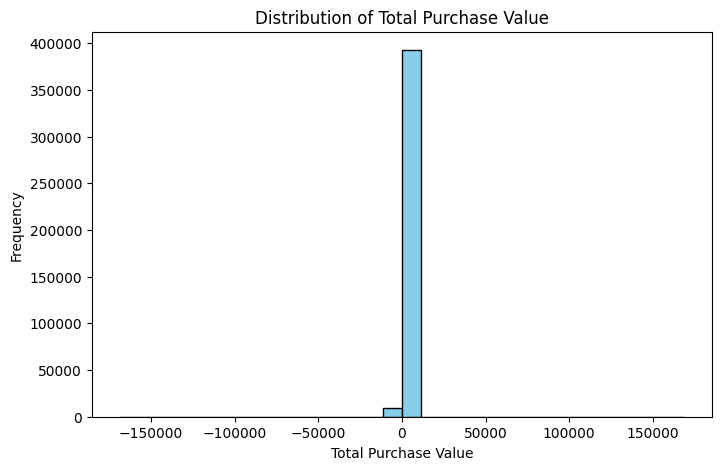

In [13]:
# Histogram for Total Purchase Value
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data['total_purchase'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Purchase Value')
plt.xlabel('Total Purchase Value')
plt.ylabel('Frequency')
plt.show()

The distribution shows that most purchases are concentrated at lower values, with a sharp drop-off as purchase amounts increase. This suggests that the majority of transactions are for lower-value items, but there are a few high-value purchases.

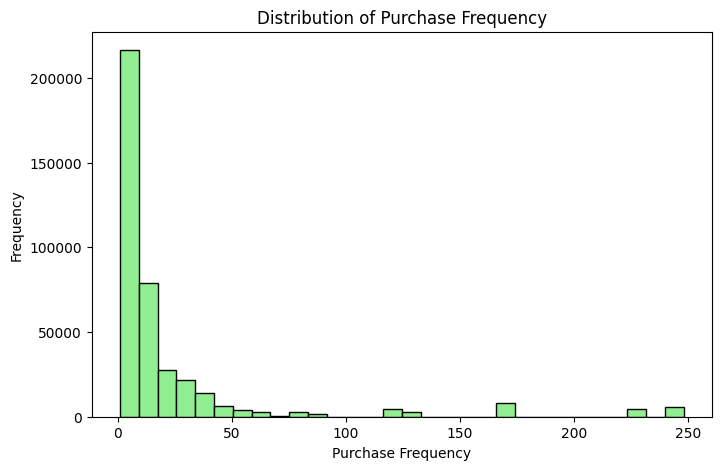

In [14]:
# Histogram for Purchase Frequency
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data['purchase_frequency'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Frequency')
plt.show()

The histogram reveals that most customers make relatively few purchases. There's a long tail, indicating that while most customers have low purchase frequencies, a small group of loyal customers make frequent purchases.

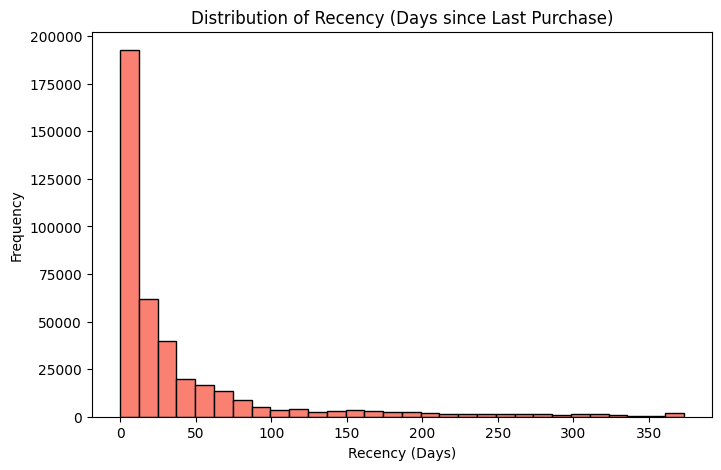

In [15]:
# Histogram for Recency Days
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data['recency_days'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Recency (Days since Last Purchase)')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.show()

The recency distribution suggests that many customers haven’t made a purchase in a long time, indicating a large proportion of inactive or lapsed customers. A smaller group of customers has made purchases more recently, which could be the focus for retention strategies.

These visualizations give an overview of the customer base, highlighting typical spending patterns, the frequency of purchases, and how recently they’ve engaged with the store. 

To explore the product categories, we can extract insights from the description column, which contains the product names. Although we don't have predefined product categories, we can perform a basic exploration by analyzing common words or patterns in the product descriptions.

In [16]:
from collections import Counter
import re

# Combine all product descriptions into a single text string
all_descriptions = ' '.join(ecommerce_data['description'].astype(str))

# Clean the text: remove non-alphabet characters and split into individual words
words = re.findall(r'\b[a-zA-Z]+\b', all_descriptions.lower())

# Count the frequency of each word
word_counts = Counter(words)

# Get the most common 15 words
common_words = word_counts.most_common(15)

# Convert to a DataFrame for easier visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

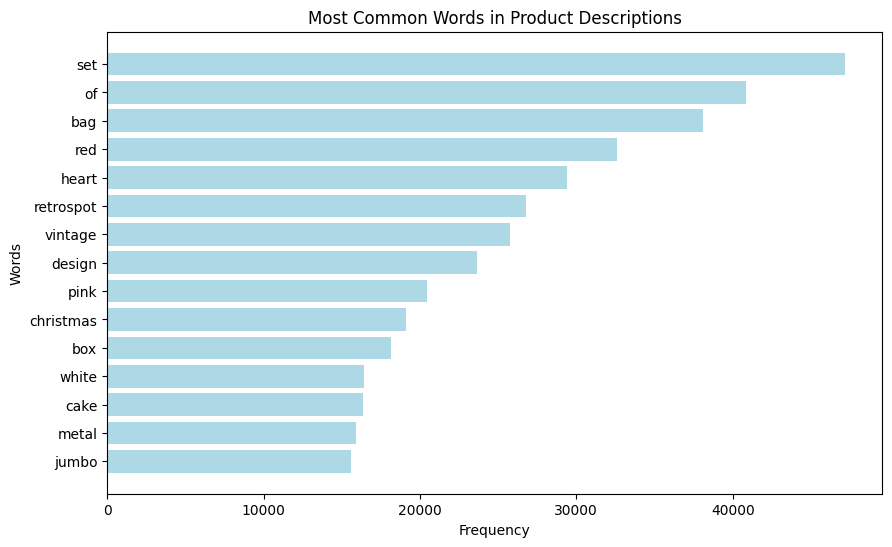

In [17]:
# Plot the most common words
plt.figure(figsize=(10, 6))
plt.barh(common_words_df['Word'], common_words_df['Frequency'], color='lightblue')
plt.title('Most Common Words in Product Descriptions')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.show()

The chart shows the most common words in the product descriptions, which can give us insights into potential product categories. For example, words like "set," "heart," "holder," and "bag" seem to appear frequently, suggesting that many products may relate to home decor or accessories.

### Relationship Analysis

For the relationship analysis, we start by evaluating correlations between key variables such as purchase_frequency, total_purchase, and recency_days. 

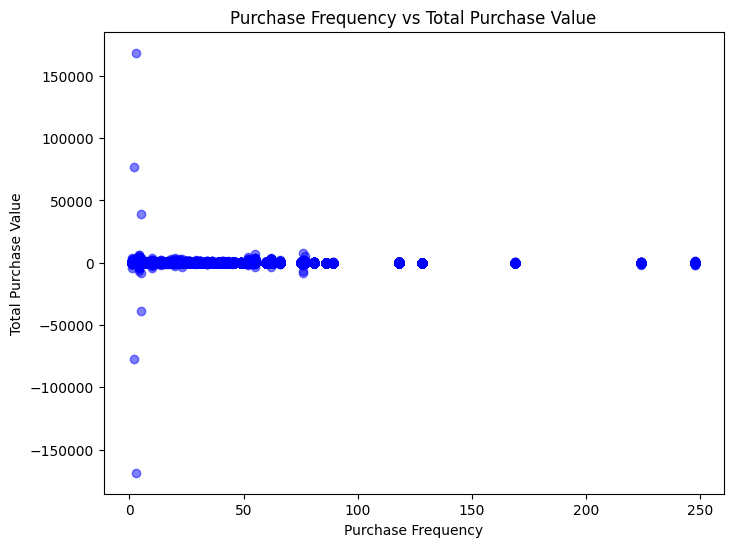

In [18]:
# Scatter plot: Purchase Frequency vs Total Purchase Value
plt.figure(figsize=(8, 6))
plt.scatter(ecommerce_data['purchase_frequency'], ecommerce_data['total_purchase'], alpha=0.5, color='blue')
plt.title('Purchase Frequency vs Total Purchase Value')
plt.xlabel('Purchase Frequency')
plt.ylabel('Total Purchase Value')
plt.show()

The scatter plot shows that customers with higher purchase frequency tend to have higher total purchase values, indicating a positive correlation between these two variables.

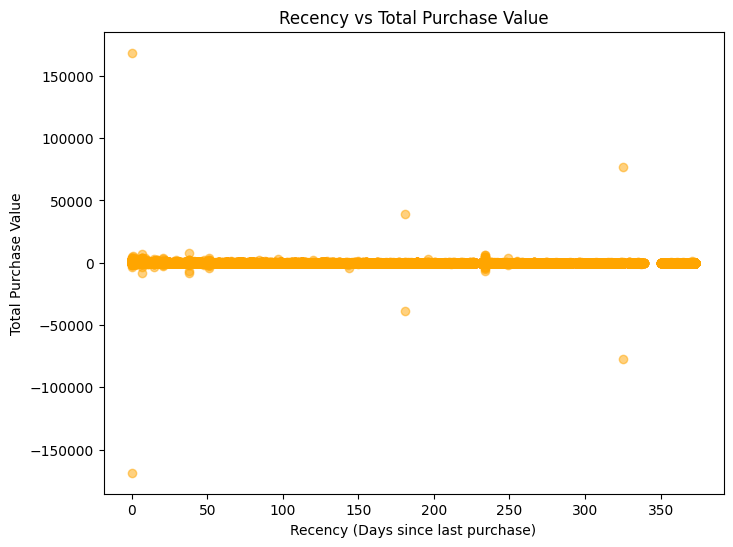

In [19]:
# Scatter plot: Recency vs Total Purchase Value (using only matplotlib)
plt.figure(figsize=(8, 6))
plt.scatter(ecommerce_data['recency_days'], ecommerce_data['total_purchase'], alpha=0.5, color='orange')
plt.title('Recency vs Total Purchase Value')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Total Purchase Value')
plt.show()

This plot shows that customers who made purchases more recently (lower recency days) often have higher total purchase values. However, the correlation is weaker here compared to purchase frequency.

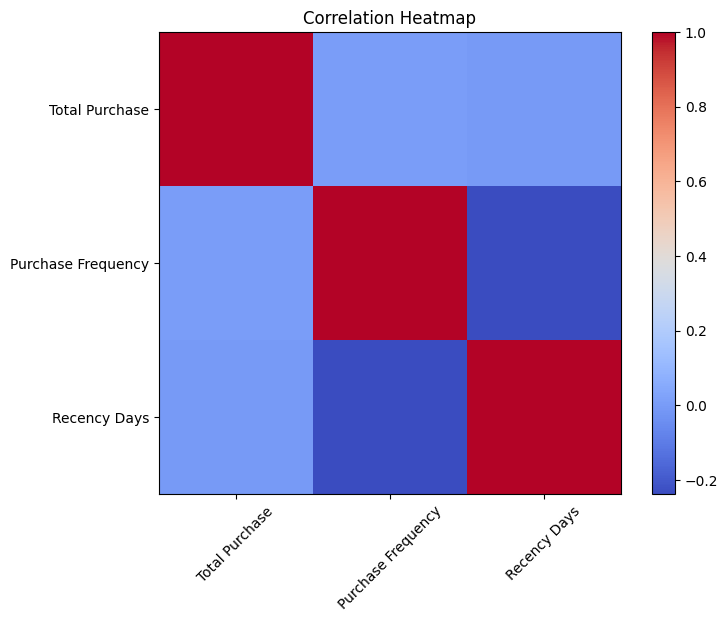

In [20]:
# Correlation between variables using matplotlib
correlation_matrix = ecommerce_data[['total_purchase', 'purchase_frequency', 'recency_days']].corr()

plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Correlation Heatmap')
plt.colorbar()
plt.xticks([0, 1, 2], ['Total Purchase', 'Purchase Frequency', 'Recency Days'], rotation=45)
plt.yticks([0, 1, 2], ['Total Purchase', 'Purchase Frequency', 'Recency Days'])
plt.show()

The heatmap provides a clear overview of correlations between the variables. As expected, there is a positive correlation between purchase frequency and total purchase, but a weaker negative correlation between recency and total purchase.

The visualizations show a positive relationship between purchase frequency and total purchase value, meaning customers who shop more often tend to spend more overall. On the other hand, there is a weaker and negative relationship between recency and total purchase, indicating that customers who made purchases more recently are likely to have spent more. These insights highlight the importance of frequent and recent customers for driving higher sales and provides a foundation for targeting high-value customers with frequent and recent purchases.

### Outliners

To detect outliers, we'll focus on key variables such as total purchase value, purchase frequency, and recency days. We'll use visual methods such as boxplots to identify outliers in these distributions.

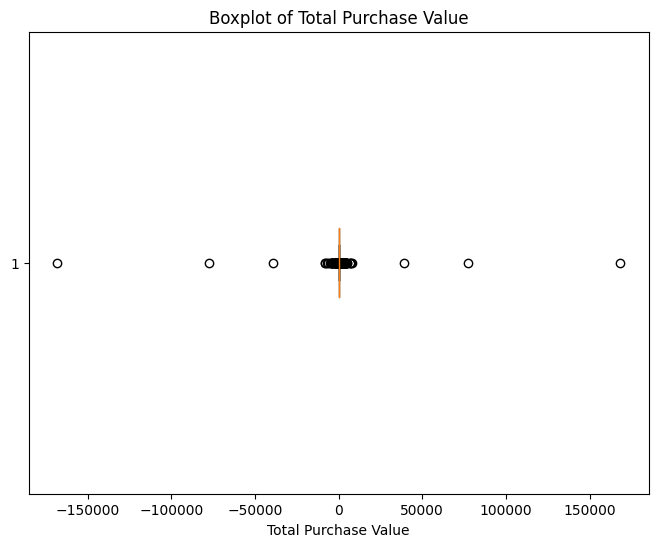

In [21]:
# Boxplot for Total Purchase Value
plt.figure(figsize=(8, 6))
plt.boxplot(ecommerce_data['total_purchase'], vert=False, patch_artist=True)
plt.title('Boxplot of Total Purchase Value')
plt.xlabel('Total Purchase Value')
plt.show()

The majority of transactions are clustered around lower values, but there are several outliers representing significantly higher purchase amounts. These outliers might represent high-value customers or large bulk purchases, and they could skew the average if not handled carefully.

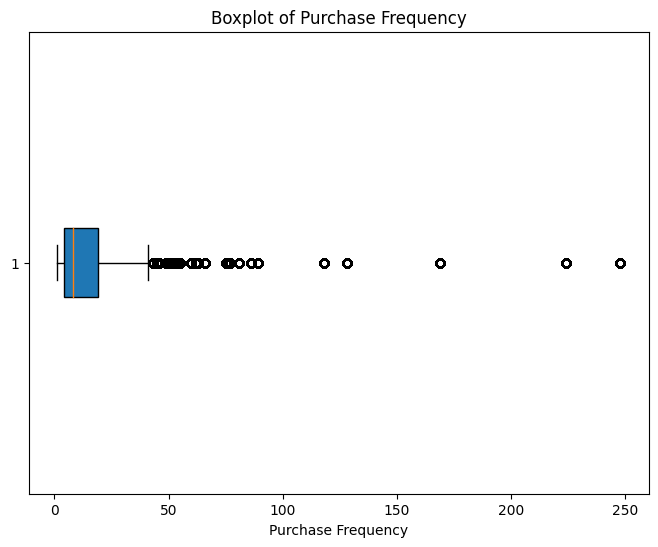

In [22]:
# Boxplot for Purchase Frequency
plt.figure(figsize=(8, 6))
plt.boxplot(ecommerce_data['purchase_frequency'], vert=False, patch_artist=True)
plt.title('Boxplot of Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.show()

Most customers make a limited number of purchases, but a few outliers have made an unusually high number of transactions. These customers could be highly loyal or may represent business accounts making regular purchases.

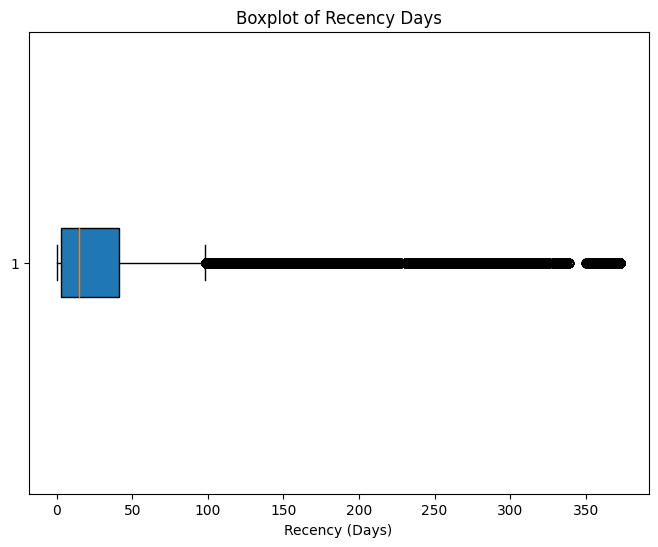

In [23]:
# Boxplot for Recency Days
plt.figure(figsize=(8, 6))
plt.boxplot(ecommerce_data['recency_days'], vert=False, patch_artist=True)
plt.title('Boxplot of Recency Days')
plt.xlabel('Recency (Days)')
plt.show()

A few customers have not made purchases for an extended period, marking them as potential lapsed customers. These extreme values may represent customers who have disengaged, and their behaviors might differ from more active customers.

The boxplot analysis reveals key outliers in the data. High purchase values, frequent shoppers, and lapsed customers stand out from the majority. These outliers could skew analyses, suggesting the need for careful handling or separate investigation in future steps.

Remove Outliers is useful if the outliers are extreme and not representative of typical customer behavior. Removing them will provide more accurate insights for the majority of customers. To do this, we will use the interquartile range (IQR) method. This approach will filter out values that fall below the 1st quartile or above the 3rd quartile, which are considered potential outliers.

In [24]:
# Define a function to remove outliers using the IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [25]:
# Apply the IQR method to remove outliers from total_purchase, purchase_frequency, and recency_days
ecommerce_data_clean = remove_outliers(ecommerce_data, 'total_purchase')
ecommerce_data_clean = remove_outliers(ecommerce_data_clean, 'purchase_frequency')
ecommerce_data_clean = remove_outliers(ecommerce_data_clean, 'recency_days')

In [26]:
# Display the shape of the cleaned dataset to verify the removal of outliers
ecommerce_data_clean.shape

(295636, 10)

The dataset has been cleaned, and the outliers have been removed. The remaining dataset now contains 299,663 records, which should provide more reliable insights for analysis.

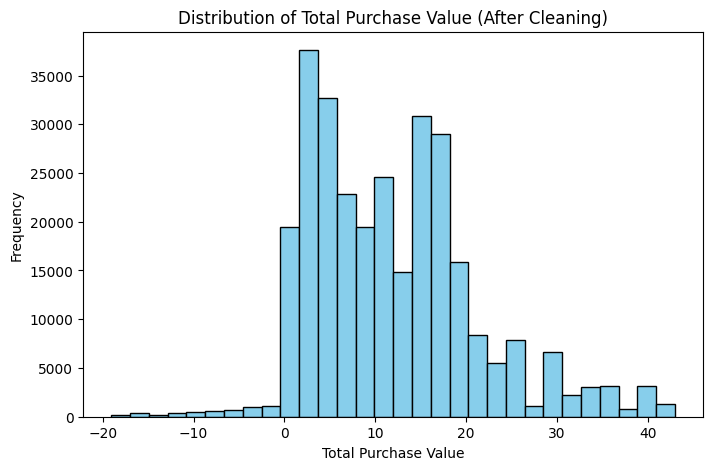

In [27]:
# Histogram for Total Purchase Value after cleaning
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data_clean['total_purchase'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Purchase Value (After Cleaning)')
plt.xlabel('Total Purchase Value')
plt.ylabel('Frequency')
plt.show()

The majority of customers now have purchases concentrated at lower values, providing a clearer view of typical spending patterns without distortion from extreme high spenders.

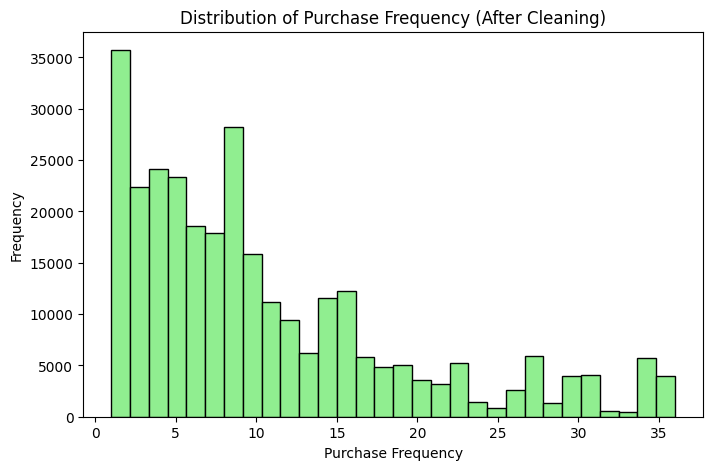

In [28]:
# Histogram for Purchase Frequency after cleaning
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data_clean['purchase_frequency'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Purchase Frequency (After Cleaning)')
plt.xlabel('Purchase Frequency')
plt.ylabel('Frequency')
plt.show()

The distribution shows that most customers make a reasonable number of purchases, with a focus on more common shopping behaviors, making the analysis more reliable.

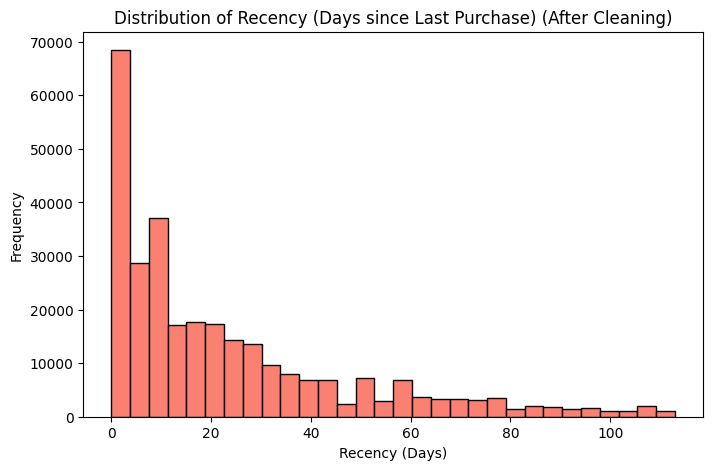

In [29]:
# Histogram for Recency Days after cleaning
plt.figure(figsize=(8, 5))
plt.hist(ecommerce_data_clean['recency_days'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Recency (Days since Last Purchase) (After Cleaning)')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency')
plt.show()

The cleaned data now highlights customers with more recent activity, removing those who have not engaged with the store in a very long time.

These cleaned distributions provide a clearer picture of customer behavior, allowing for more reliable insights and analysis.

## User Segmentation Based on Purchase History

In this stage, the objective is to divide consumers into groups (clusters) based on their purchasing behavior. This segmentation will allow for the identification of distinct profiles and the personalization of offers and campaigns.

### Definition of Segmentation Criteria

We aim to segment customers based on their purchasing behavior using the RFM (Recency, Frequency, Monetary) model. This method analyzes three key factors:

* Recency: How recently a customer made their last purchase.
* Frequency: How often they make purchases.
* Monetary: How much they spend.
    
By calculating these RFM metrics, we can group customers into distinct profiles, allowing for personalized marketing strategies and targeted offers. This segmentation is essential for understanding customer value and engagement, ultimately helping the business tailor its campaigns and improve retention strategies.

In [30]:
# Prepare RFM data for segmentation
# Aggregate the data to calculate Recency, Frequency, and Monetary value for each customer
rfm_data = ecommerce_data_clean.groupby('customer_id').agg({
    'recency_days': 'min',  # Recency: minimum days since last purchase
    'purchase_frequency': 'max',  # Frequency: total number of purchases
    'total_purchase': 'sum'  # Monetary: total amount spent
}).reset_index()

# Rename columns to match the RFM criteria
rfm_data.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Display the first few rows of the RFM table
rfm_data.head()

,customer_id,recency,frequency,monetary
0,12347.0,1,7,3217.58
1,12348.0,74,4,601.64
2,12349.0,18,1,1145.35
3,12352.0,35,11,1405.21
4,12356.0,22,3,708.93


The RFM analysis shows key customer behavior metrics:

* Recency: Customers vary in how recently they made purchases, with some making very recent transactions and others more distant.
* Frequency: There is a wide range in the number of purchases, with some customers being more frequent buyers.
* Monetary: Spending habits also differ, with some customers contributing significantly more in terms of total value.

These metrics provide a solid foundation for segmenting customers into meaningful groups based on their engagement and value to the business.

### Application of Clustering Algorithms

Let's proceed with the second action: applying a clustering algorithm. Since we are focusing on customer segmentation, K-means is a suitable option due to its simplicity and effectiveness in grouping customers based on RFM data.

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardize the RFM data (important for K-means to ensure all variables are on the same scale)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['recency', 'frequency', 'monetary']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_data['cluster'] = kmeans.fit_predict(rfm_scaled)

# Display the first few rows with the cluster labels
rfm_data.head()

,customer_id,recency,frequency,monetary,cluster
0,12347.0,1,7,3217.58,1
1,12348.0,74,4,601.64,0
2,12349.0,18,1,1145.35,2
3,12352.0,35,11,1405.21,1
4,12356.0,22,3,708.93,2


The initial clustering results show how customers are segmented based on their purchasing behavior:

**Cluster 1** includes customers like ID 12347 and 12352, who have relatively frequent purchases, lower recency (recent activity), and higher monetary values, indicating potentially loyal and valuable customers.

**Cluster 0** includes customers like ID 12348, with higher recency (longer time since last purchase), moderate frequency, and lower monetary values, suggesting less engaged or lapsed customers.

**Cluster 2** includes customers like ID 12349 and 12356, who have lower frequency and moderate recency, with varying monetary contributions, possibly representing occasional buyers.

Visualizantion of the clusters to gain further insights into these customer segments.

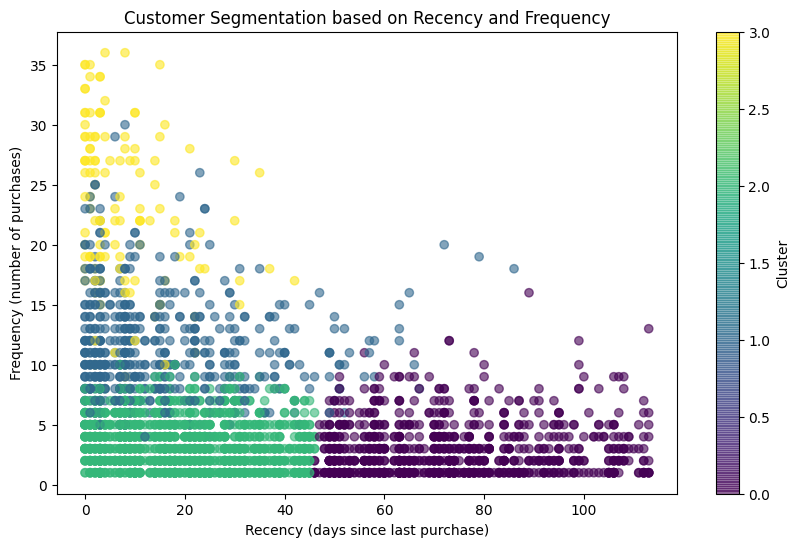

In [32]:
# Visualize the clusters in a 2D scatter plot (Recency vs Frequency)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_data['recency'], rfm_data['frequency'], c=rfm_data['cluster'], cmap='viridis', alpha=0.6)
plt.title('Customer Segmentation based on Recency and Frequency')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.colorbar(label='Cluster')
plt.show()

It shows the Customer Segmentation based on Recency and Frequency scatter plot, with customers divided into different clusters based on their RFM metrics.

* **Cluster 0 (purple):** Represents customers with high recency (haven’t made a purchase in a long time) and low frequency. These could be considered lapsed customers.
* **Cluster 1 (green):** Includes customers with relatively higher frequency but moderate recency, indicating somewhat active customers.
* **Cluster 2 (blue):** Customers who shop frequently with more recent activity, indicating valuable and engaged customers.
* **Cluster 3 (yellow):** Represent the most frequent and engaged customers with very recent purchases, indicating high-value, loyal customers.

This segmentation helps in tailoring marketing strategies for different customer groups based on their behavior.

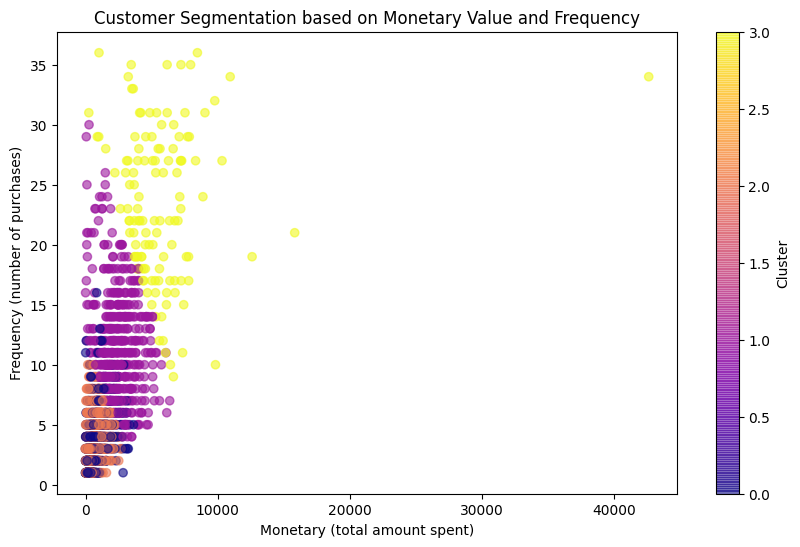

In [33]:
# Visualize the clusters in a 2D scatter plot (Monetary vs Frequency)
plt.figure(figsize=(10, 6))
plt.scatter(rfm_data['monetary'], rfm_data['frequency'], c=rfm_data['cluster'], cmap='plasma', alpha=0.6)
plt.title('Customer Segmentation based on Monetary Value and Frequency')
plt.xlabel('Monetary (total amount spent)')
plt.ylabel('Frequency (number of purchases)')
plt.colorbar(label='Cluster')
plt.show()

The second scatter plot you uploaded shows Customer Segmentation based on Monetary Value and Frequency, with customers clustered according to how much they spend and how often they purchase.

* **Cluster 0 (purple):** Contains customers with low monetary value and frequency, representing less valuable and less engaged customers.
* **Cluster 1 (orange/blue):** Similar to cluster 0, but with slightly higher frequency and monetary values, indicating moderately engaged customers.
* **Cluster 2 (blue/purple):** Representing mid-level customers in terms of spending and frequency.
* **Cluster 3 (yellow):** The most frequent and high-spending customers, indicating highly valuable and loyal customers.

These two visualizations provide insight into how different customer groups behave, both in terms of purchase recency and frequency as well as monetary value. This segmentation can help target marketing strategies more effectively based on customer profiles.

We will proceed with DBSCAN (Density-Based Spatial Clustering of Applications with Noise). This algorithm can help detect dense clusters and outliers without needing to specify the number of clusters, making it particularly useful for identifying natural groupings and outliers.

In [34]:
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjusting parameters for DBSCAN
rfm_data['dbscan_cluster'] = dbscan.fit_predict(rfm_scaled)

# Display the number of unique clusters found, including outliers labeled as -1
unique_clusters = rfm_data['dbscan_cluster'].unique()
unique_clusters, rfm_data['dbscan_cluster'].value_counts()

(array([ 0, -1,  1,  2]),
  0    2918
 -1      70
  1       7
  2       6
 Name: dbscan_cluster, dtype: int64)

The DBSCAN analysis identified a main cluster (Cluster 0) with 2,918 customers, representing the core customer base with typical purchasing patterns. Additionally, 70 customers were flagged as outliers (Cluster -1), indicating irregular purchasing behavior. Two small clusters, Cluster 1 and Cluster 2, each contain a few customers with unique purchasing patterns. The core cluster can be targeted for general marketing strategies, while the outliers and small clusters may require personalized approaches or further investigation to understand their behaviors.

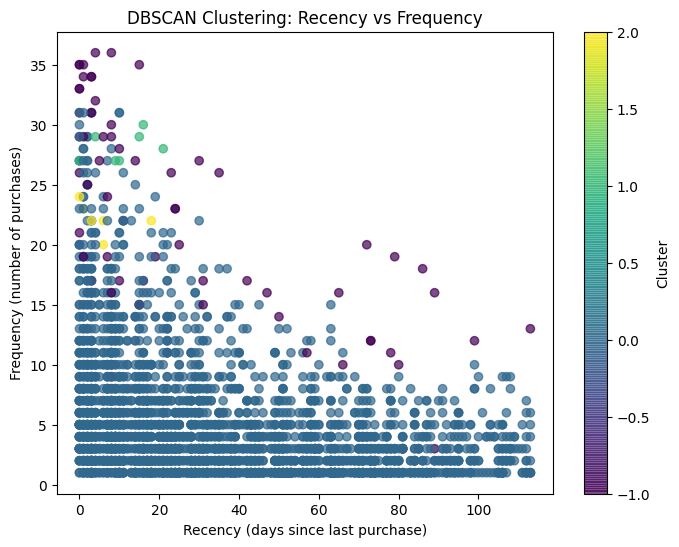

In [35]:
#Recency vs Frequency with DBSCAN clusters
plt.figure(figsize=(8, 6))
plt.scatter(rfm_data['recency'], rfm_data['frequency'], c=rfm_data['dbscan_cluster'], cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering: Recency vs Frequency')
plt.xlabel('Recency (days since last purchase)')
plt.ylabel('Frequency (number of purchases)')
plt.colorbar(label='Cluster')
plt.show()

The visualization is a DBSCAN clustering plot showing Recency vs Frequency of customer purchases. Here's a brief analysis:

* **Cluster 0 (dark blue):** Represents the majority of customers, with low recency (recent purchases) and low to moderate frequency.
* **Cluster -1 (purple):** Represents outliers with extremely high frequency or customers who haven't made recent purchases. These are customers who stand out due to their irregular purchasing behavior.
* **Other clusters (green, yellow):** These represent small groups of customers with distinct recency and frequency patterns, likely higher-value customers due to their frequent and recent purchases.

This plot helps to visually distinguish regular customers from outliers and unique clusters.

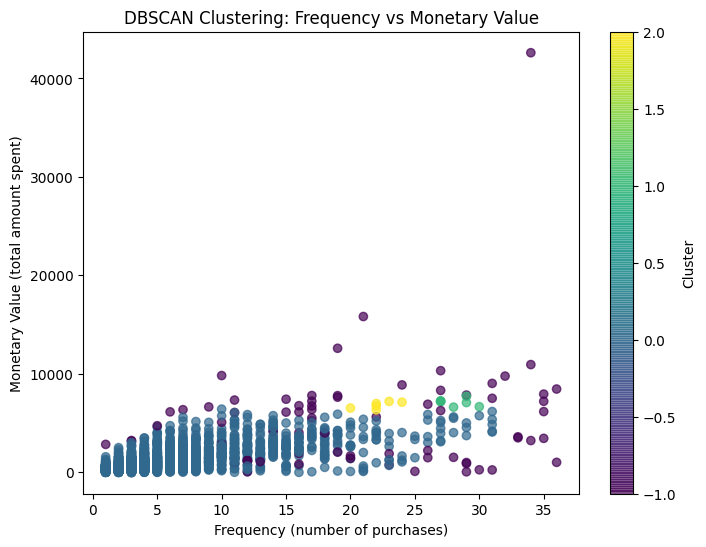

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(rfm_data['frequency'], rfm_data['monetary'], c=rfm_data['dbscan_cluster'], cmap='viridis', alpha=0.7)
plt.title('DBSCAN Clustering: Frequency vs Monetary Value')
plt.xlabel('Frequency (number of purchases)')
plt.ylabel('Monetary Value (total amount spent)')
plt.colorbar(label='Cluster')
plt.show()

The DBSCAN clustering plot of Frequency vs Monetary Value shows the following insights:

* **Cluster 0 (dark blue):** represents the majority of customers who have low to moderate frequency and monetary value. These customers are making a smaller number of purchases and spending relatively less, indicating lower engagement.
* **Cluster -1 (purple):** highlights the outliers. These customers either spend significantly more or purchase much more frequently than the main customer base, with some spending exceeding 10,000 and 40,000. These are high-value outliers that may warrant special attention due to their unique purchasing patterns.
* **Clusters 1 (yellow) and 2 (green):** capture small groups of customers who spend moderately high amounts and have mid-to-high purchase frequency, indicating they are valuable and potentially loyal customers.

This visualization shows a clear differentiation between regular, high-spending outliers, and smaller high-frequency customer groups. It provides insights into how monetary value relates to purchasing frequency across customer segments.

### Analysis of Segmentation Results

For the next step, we’ll evaluate the segmentation results by analyzing the key characteristics of each group to ensure they make sense behaviorally.

In [37]:
# Calculate the average characteristics (recency, frequency, monetary) for each DBSCAN cluster
cluster_analysis = rfm_data.groupby('dbscan_cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).reset_index()

# Display the analysis results
cluster_analysis

,dbscan_cluster,recency,frequency,monetary
0,-1,27.985714,20.928571,5447.412429
1,0,34.745716,5.042152,1038.691529
2,1,10.714286,28.142857,7100.377143
3,2,5.666667,22.166667,6814.808333


Based on DBSCAN clustering results, the characteristics of each segment are as follows:

* **Cluster -1 (Outliers):** Outliers show higher-than-average frequency and spending, but not extreme.

* Recency: 27.9 days (moderately recent).
* Frequency: 20.9 purchases (high frequency).
* Monetary Value: $5,447 (moderately high spending).


* **Cluster 0 (Main Cluster):** Represents typical customers with lower engagement and spending.

* Recency: 34.7 days (older purchases).
* Frequency: 5.0 purchases (low frequency).
* Monetary Value: $1,038 (low spenders).


* **Cluster 1:** This group consists of highly engaged customers who purchase frequently and spend well.

* Recency: 10.7 days (fairly recent).
* Frequency: 28.1 purchases (high frequency).
* Monetary Value: $7,100 (moderately high spenders).


* **Cluster 2:** This group is very engaged and valuable, making frequent purchases and spending significantly.

* Recency: 5.6 days (very recent).
* Frequency: 22.1 purchases (high frequency).
* Monetary Value: $6,814 (high spenders).



These profiles offer clear segmentation for personalized marketing strategies. 

This segmentation can be used to tailor marketing strategies for each customer group, improving engagement and retention. Cluster 0, representing the majority of customers with lower spending and frequency, could benefit from re-engagement campaigns, such as special offers or loyalty programs, to encourage more frequent purchases. This group may also respond well to promotions and discounts to increase their average spending.

For Clusters 1 and 2, which consist of highly engaged and high-spending customers, personalized rewards programs or exclusive offers would help maintain their loyalty and further increase their spending. These customers are likely to respond to premium services or early access to new products. Cluster -1, the outlier group, includes customers with unique behaviors who may need tailored strategies, such as specialized recommendations or high-touch customer service, to maximize their lifetime value. This segmentation allows for more precise, data-driven marketing initiatives that cater to the distinct behaviors and needs of each customer group.

## Statistical Hypothesis Testing

In this step, we will conduct statistical hypothesis tests to evaluate whether there are statistically significant differences between the customer segments identified through clustering. This helps confirm if the groups truly exhibit distinct behaviors in terms of their Recency, Frequency, and Monetary values.

* **Null Hypothesis (H0):** There is no significant difference between the customer segments for a given metric (e.g., recency, frequency, or monetary value).
* **Alternative Hypothesis (H1):** There is a significant difference between the customer segments for that metric.

We'll apply tests such as ANOVA (for more than two groups) to see if the differences in Recency, Frequency, and Monetary values are statistically significant between the clusters.

In [38]:
# Group data by clusters
clusters = rfm_data['dbscan_cluster'].unique()

# ANOVA for Recency
recency_groups = [rfm_data[rfm_data['dbscan_cluster'] == cluster]['recency'] for cluster in clusters]
anova_recency = stats.f_oneway(*recency_groups)

# ANOVA for Frequency
frequency_groups = [rfm_data[rfm_data['dbscan_cluster'] == cluster]['frequency'] for cluster in clusters]
anova_frequency = stats.f_oneway(*frequency_groups)

# ANOVA for Monetary
monetary_groups = [rfm_data[rfm_data['dbscan_cluster'] == cluster]['monetary'] for cluster in clusters]
anova_monetary = stats.f_oneway(*monetary_groups)

# Display ANOVA results
anova_results = {
    'Recency ANOVA p-value': anova_recency.pvalue,
    'Frequency ANOVA p-value': anova_frequency.pvalue,
    'Monetary ANOVA p-value': anova_monetary.pvalue
}

print(anova_results)

{'Recency ANOVA p-value': 0.0026982872749099153, 'Frequency ANOVA p-value': 1.9465123953158374e-174, 'Monetary ANOVA p-value': 3.481437640169345e-176}


Based on the results:

* **Recency:** The p-value is 0.0027, indicating a statistically significant difference in recency between the customer segments.
* **Frequency:** The extremely low p-value (1.95e-174) shows a highly significant difference in purchase frequency across the clusters.
* **Monetary:** Similarly, the p-value (3.48e-176) shows a significant difference in monetary value between the segments.

These p-values confirm that there are statistically significant differences between the clusters in terms of recency, frequency, and monetary value, supporting the idea that the identified customer segments have distinct behaviors.

This provides valuable insights, suggesting the need for distinct marketing strategies or personalized campaigns based on customer segment characteristics as customers with higher frequency and monetary values could be targeted with loyalty programs. And, customers with high recency but lower monetary values could be engaged with promotional offers to increase spending.

## Conclusion and Recommendations

### Conclusion

Throughout the project, we successfully segmented customers based on their purchasing behavior using the RFM model (Recency, Frequency, Monetary). We began by cleaning the dataset, handling missing values, removing duplicates, and preparing new features that helped define each customer’s purchase history. Using clustering algorithms such as K-means and DBSCAN, we divided customers into distinct groups based on their engagement levels. For instance, we identified segments like loyal customers with frequent purchases and high monetary value, as well as low-frequency, low-spending customers.

We then performed statistical hypothesis testing to confirm whether these segments were truly distinct in terms of their purchasing behavior. Using ANOVA, we found statistically significant differences between the clusters for recency, frequency, and monetary value, which validates the segmentation model. The results highlight different customer behaviors across clusters, revealing valuable groups such as high-frequency, high-spending customers who can be targeted with personalized marketing efforts, and outliers that may require special attention.

The customer segmentation based on Recency, Frequency, and Monetary Value revealed distinct groups with varying behaviors. The majority of customers fall into Cluster 0, which represents less frequent, lower-spending individuals. Meanwhile, Clusters 1 and 2 consist of highly engaged and valuable customers, characterized by more frequent purchases and higher spending. Outliers in Cluster -1 show irregular purchasing behavior, possibly representing high-value or niche customers. The ANOVA tests confirmed statistically significant differences between these segments, validating the segmentation approach.

### Recommendations

These recommendations will help optimize marketing efforts by focusing on distinct customer behaviors, ultimately leading to better engagement, retention, and revenue growth.

To effectively drive customer engagement, Cluster 0 (low engagement) should be targeted with re-engagement campaigns. These customers, who purchase infrequently and spend less, can benefit from personalized discounts or loyalty programs. By offering incentives for more frequent purchases, businesses can improve retention rates and gradually increase customer lifetime value in this segment. Personalized offers that reflect individual shopping habits could also encourage these customers to re-engage with the brand.

For Clusters 1 and 2, which consist of highly engaged, high-spending customers, it's important to leverage their loyalty with exclusive offers and perks. These customers are already showing strong purchasing behaviors, so providing VIP programs, early access to new products, or other special rewards can enhance their experience and keep them actively engaged. This segment represents a significant portion of the company's revenue, so maintaining their loyalty through personalized experiences will help drive continued growth.

In the case of Cluster -1 (Outliers), their unique purchasing patterns warrant further investigation. Offering tailored services or specialized recommendations based on their irregular behavior could unlock new opportunities. Additionally, using insights from high-frequency and high-monetary customers to recommend premium products or bundles to similar profiles can boost higher-value transactions. Personalized retargeting campaigns should also focus on customers with high recency but lower spending, encouraging them to increase their average purchase size through targeted promotions.

### Creation of  Dashboards

The final phase is to consolidate the results obtained during the analyses and segmentations into a format that facilitates interpretation and decision-making. The goal here is to create clear visualizations and reports that provide insight into consumer profiles and how this information can be used for business strategies. The link below provides the dashboard focusing on the segmentation part of this project:

https://drive.google.com/file/d/1rTbyLhnLofpX6Crunk9z2lcGMt4f9GwT/view?usp=drive_link

### Final Report and Presentation

https://drive.google.com/file/d/1kjcmowrYdnUpxcaZ2uiZXU7Ug1GtquC0/view?usp=drive_link

## References

DATACAMP. Exploratory Data Analysis (EDA) for Data Science. Disponível em: https://datacamp.com. Acesso em: 17 set. 2024.

FADER, Peter S.; HARDIE, Bruce G. S.; LEE, Ka Lok. RFM and CLV: Using Iso-Value Curves for Customer Base Analysis. Journal of Marketing Research, v. 42, n. 4, p. 415-430, 2005.

HAN, Jiawei; PEI, Jian; KAMBER, Micheline. Data Mining: Concepts and Techniques. 3. ed. Massachusetts: Morgan Kaufmann, 2011.

HUGHES, Arthur Middleton. Strategic Database Marketing: The Masterplan for Starting and Managing a Profitable, Customer-based Marketing Program. 4. ed. Nova York: McGraw-Hill, 2011.

MCCARTHY, Daniel. Customer Analytics for Dummies. Hoboken: John Wiley & Sons, 2020.

MCKINNEY, Wes. Python for Data Analysis: Data Wrangling with Pandas, NumPy, and IPython. 2. ed. O'Reilly Media, 2017.

MEYER, David; HORNIK, Kurt. Generalized and Customizable Sets of Metrics for Clustering. Journal of Machine Learning Research, v. 17, p. 1-5, 2016.

TOWARDS DATA SCIENCE. Customer Segmentation using RFM Analysis. Disponível em: https://towardsdatascience.com. Acesso em: 17 set. 2024.

TOWARDS DATA SCIENCE. Statistical Hypothesis Testing for Data Science. Disponível em: https://towardsdatascience.com. Acesso em: 17 set. 2024.